In [1]:
import os
import pycaret
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn
patch_sklearn()
from pycaret.classification import *

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


#### Load data

In [2]:
train = pd.read_csv('../data/train.csv')
train.shape

(159256, 24)

#### Check data stats, missing values

In [3]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,159256.0,79627.500000,45973.391572,0.0,39813.75,79627.5,119441.25,159255.0
age,159256.0,44.306626,11.842286,20.0,40.00,40.0,55.00,85.0
height(cm),159256.0,165.266929,8.818970,135.0,160.00,165.0,170.00,190.0
weight(kg),159256.0,67.143662,12.586198,30.0,60.00,65.0,75.00,130.0
waist(cm),159256.0,83.001990,8.957937,51.0,77.00,83.0,89.00,127.0
eyesight(left),159256.0,1.005798,0.402113,0.1,0.80,1.0,1.20,9.9
eyesight(right),159256.0,1.000989,0.392299,0.1,0.80,1.0,1.20,9.9
hearing(left),159256.0,1.023974,0.152969,1.0,1.00,1.0,1.00,2.0
hearing(right),159256.0,1.023421,0.151238,1.0,1.00,1.0,1.00,2.0
systolic,159256.0,122.503648,12.729315,77.0,114.00,121.0,130.00,213.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

#### Pycaret will generate polynomial features. Let's add several extra features

In [5]:
train['bmi'] = 10000*train['weight(kg)']/train['height(cm)']/train['height(cm)']
train['liver_enz'] = train['AST'] + train['ALT'] + train['Gtp']
train['totalDL'] = train['HDL'] + train['LDL']

#### Check for categorical features

In [6]:

for ft in train.columns:
    if len(train[ft].value_counts())<10:
        print(45*'=')
        print(ft,)
        print(train[ft].value_counts())
print(45*'=')
        

hearing(left)
1    155438
2      3818
Name: hearing(left), dtype: int64
hearing(right)
1    155526
2      3730
Name: hearing(right), dtype: int64
Urine protein
1    150862
2      5609
3      2228
4       477
5        74
6         6
Name: Urine protein, dtype: int64
dental caries
0    127724
1     31532
Name: dental caries, dtype: int64
smoking
0    89603
1    69653
Name: smoking, dtype: int64


`dental caries` is the binary feature. The rest can be treated as numerical ones.

In [7]:
ignore_features = ['id']
categorical_features = ['dental caries']
TARGET = 'smoking'

numeric_features = train.columns.values.tolist()
for fetaure in categorical_features+ignore_features+[TARGET]:
    numeric_features.remove(fetaure)



#### Setup pycaret experiment

In [8]:
s = setup(train,
            # numeric_features=numeric_features,
            # categorical_features=categorical_features,
            # ordinal_features=ordinal_features,
            # bin_numeric_features = bin_numeric_features,
            ignore_features=ignore_features,
            # remove_multicollinearity=True,
            # low_variance_threshold = 0.1,
            train_size=0.8, 
            fold = 5,
            normalize=True, 
            normalize_method='robust',
            # transformation=True,  
            polynomial_features=True, 
            polynomial_degree=2,
            feature_selection_estimator=True,
            fix_imbalance=True,
            target = TARGET, 
            session_id = 111, 
            )


,Description,Value
0,Session id,111
1,Target,smoking
2,Target type,Binary
3,Original data shape,"(159256, 27)"
4,Transformed data shape,"(175216, 351)"
5,Transformed train set shape,"(143364, 351)"
6,Transformed test set shape,"(31852, 351)"
7,Ignore features,1
8,Numeric features,25
9,Preprocess,True


#### Let's run a set of models and pick the best one

In [9]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7809,0.8651,0.8164,0.7201,0.7652,0.5613,0.5652,35.8260
lightgbm,Light Gradient Boosting Machine,0.7795,0.8634,0.8251,0.7148,0.7660,0.5595,0.5647,69.2000
xgboost,Extreme Gradient Boosting,0.7763,0.8585,0.8086,0.7165,0.7598,0.5520,0.5555,17.5080
gbc,Gradient Boosting Classifier,0.7753,0.8593,0.8406,0.7035,0.7660,0.5532,0.5613,153.3880
rf,Random Forest Classifier,0.7738,0.8532,0.8169,0.7098,0.7595,0.5480,0.5528,14.0520
et,Extra Trees Classifier,0.7721,0.8534,0.8099,0.7099,0.7566,0.5441,0.5483,14.8380
ridge,Ridge Classifier,0.7665,0.0000,0.8491,0.6892,0.7608,0.5375,0.5487,10.8100
ada,Ada Boost Classifier,0.7659,0.8490,0.8352,0.6927,0.7573,0.5349,0.5437,37.9300
lda,Linear Discriminant Analysis,0.7654,0.8472,0.8469,0.6884,0.7595,0.5352,0.5462,13.3440
lr,Logistic Regression,0.7642,0.8463,0.8340,0.6909,0.7557,0.5317,0.5405,18.6280


`Catboost` is the best model. Proceed with it.

#### Tune the best model

In [10]:
tuned_best = tune_model(best, search_library = 'scikit-learn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7827,0.8660,0.8225,0.7203,0.7680,0.5653,0.5697
1,0.7811,0.8625,0.8206,0.7187,0.7663,0.5621,0.5665
2,0.7807,0.8650,0.8229,0.7173,0.7665,0.5615,0.5662
3,0.7793,0.8635,0.8269,0.7139,0.7662,0.5594,0.5648
4,0.7756,0.8578,0.8185,0.7117,0.7614,0.5515,0.5563
Mean,0.7799,0.8630,0.8223,0.7164,0.7657,0.5600,0.5647
Std,0.0024,0.0029,0.0028,0.0032,0.0023,0.0046,0.0045


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [11]:
print(tuned_best)

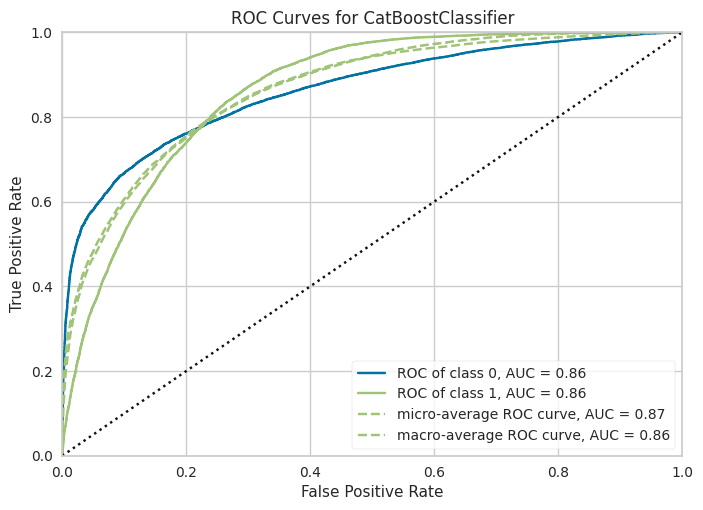

In [12]:
plot_model(tuned_best)

#### Top 10 important features

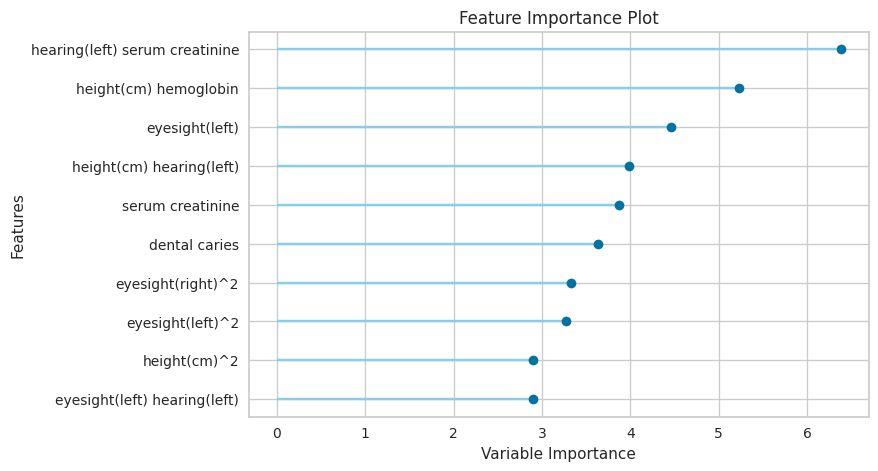

In [13]:
plot_model(tuned_best, plot = 'feature')

#### Here is the confusion matrix
The model is good enough.

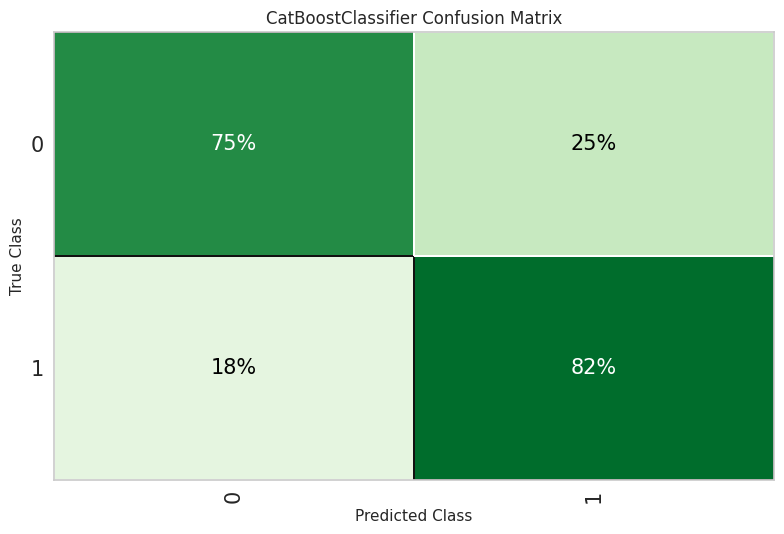

In [14]:
plot_model(tuned_best, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

#### Deploy the model as API in a docker container

In [16]:
# create api
create_api(tuned_best, 'smoking_clf_api')



API successfully created. This function only creates a POST API, it doesn't run it automatically. To run your API, please run this command --> !python smoking_clf_api.py


In [17]:
# create docker
create_docker('smoking_clf_api')

Writing requirements.txt
Writing Dockerfile
Dockerfile and requirements.txt successfully created.
    To build image you have to run --> !docker image build -f "Dockerfile" -t IMAGE_NAME:IMAGE_TAG .
            
